# **Quora Question Pairs**

Where else but Quora can a physicist help a chef with a math problem and get cooking tips in return? Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.

Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.

Currently, Quora uses a Random Forest model to identify duplicate questions. In this competition, Kagglers are challenged to tackle this natural language processing problem by applying advanced techniques to classify whether question pairs are duplicates or not. Doing so will make it easier to find high quality answers to questions resulting in an improved experience for Quora writers, seekers, and readers.

# **Dataset Description**

The goal of this competition is to predict which of the provided pairs of questions contain two questions with the same meaning. The ground truth is the set of labels that have been supplied by human experts. The ground truth labels are inherently subjective, as the true meaning of sentences can never be known with certainty. Human labeling is also a 'noisy' process, and reasonable people will disagree. As a result, the ground truth labels on this dataset should be taken to be 'informed' but not 100% accurate, and may include incorrect labeling. We believe the labels, on the whole, to represent a reasonable consensus, but this may often not be true on a case by case basis for individual items in the dataset.

Please note: as an anti-cheating measure, Kaggle has supplemented the test set with computer-generated question pairs. Those rows do not come from Quora, and are not counted in the scoring. All of the questions in the training set are genuine examples from Quora.

In [1]:
# Import the required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df=pd.read_csv("train.csv.zip")

In [3]:
df

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


# **Basic Checks**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [5]:
df.shape

(404290, 6)

In [6]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [7]:
df.duplicated().sum()

0

0    255027
1    149263
Name: is_duplicate, dtype: int64
0    63.080215
1    36.919785
Name: is_duplicate, dtype: float64


<AxesSubplot:>

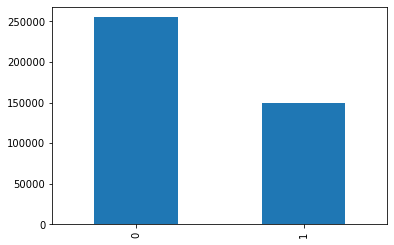

In [8]:
# Distribution of duplicate and non-duplicate questions

print(df['is_duplicate'].value_counts())
print((df['is_duplicate'].value_counts()/df['is_duplicate'].count())*100)
df['is_duplicate'].value_counts().plot(kind='bar')

In [2]:
#dataset is unbalanced

In [9]:
# Repeated questions

qid = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
print('Number of unique questions',np.unique(qid).shape[0])
x = qid.value_counts()>1
print('Number of questions getting repeated',x[x].shape[0])

Number of unique questions 537933
Number of questions getting repeated 111780


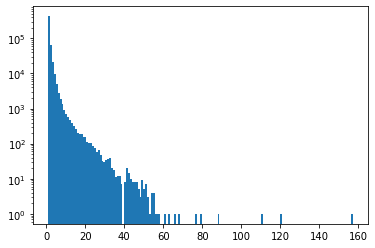

In [10]:
# Repeated questions histogram

plt.hist(qid.value_counts().values,bins=160)
plt.yscale('log')
plt.show()

In [3]:
#from the given graph it is shown 
#some of the question are repeated 160 times ,120 times,110 times

In [11]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [12]:
df.dropna(axis=0,inplace=True)

In [13]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

**from 404290 questions i have taken a sample 30000 questions**

In [14]:
new_df = df.sample(30000)

In [15]:
ques_df = new_df[['question1','question2']]
ques_df.head()

,question1,question2
51046,Who is the best footballer in the history of f...,Which is the best football team and why?
128608,How do I really make money online?,What is best way to make money online?
385317,What are the best Adobe Premiere third party p...,Adobe's cloud subscription for photo suite is ...
314367,What is similar to the motion of the stars and...,How is the Sun different from other stars on t...
193853,"Why is Manaphy anxious in ""Pokémon Ranger and ...","Why is ""Pokemon Ranger and the Temple of the S..."


# **Bag of words**

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(ques_df['question1']) + list(ques_df['question2'])

cv = CountVectorizer(max_features=3000)
q1_arr, q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)

In [17]:
temp_df1 = pd.DataFrame(q1_arr, index= ques_df.index)
temp_df2 = pd.DataFrame(q2_arr, index= ques_df.index)
temp_df = pd.concat([temp_df1, temp_df2], axis=1)
temp_df.shape

(30000, 6000)

In [18]:
temp_df1

,0,1,2,3,4,5,6,7,8,9,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
51046,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
128608,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
385317,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
314367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
193853,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11738,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
375220,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
307665,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
183527,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
temp_df['is_duplicate'] = new_df['is_duplicate']

In [20]:
temp_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2991,2992,2993,2994,2995,2996,2997,2998,2999,is_duplicate
51046,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
128608,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
385317,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
314367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
193853,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# **Model Creation**

# **Using Random Forest Classifer**

In [21]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(temp_df.iloc[:,0:-1].values,temp_df.iloc[:,-1].values,test_size=0.2,random_state=1)

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

0.7266666666666667

# **Using XGBOOST Classifier**

In [23]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
accuracy_score(y_test,y_pred)

0.7118333333333333

# **New Feature Engineering**

q1 len = char length of q1

q2 len = char length of q2

q1 words = words in q1

q2 words = word in q2

word_common = common uniwue words

word_total = total words in q1 + total words in q2

word_share = word common / word total

In [51]:
new_df = df.sample(20000,random_state=2)

In [52]:
new_df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

0    12528
1     7472
Name: is_duplicate, dtype: int64
0    62.64
1    37.36
Name: is_duplicate, dtype: float64


<AxesSubplot:>

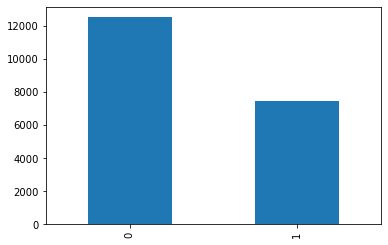

In [53]:
# Distribution of duplicate and non-duplicate questions

print(new_df['is_duplicate'].value_counts())
print((new_df['is_duplicate'].value_counts()/new_df['is_duplicate'].count())*100)
new_df['is_duplicate'].value_counts().plot(kind='bar')

In [54]:
# Repeated questions

qid = pd.Series(new_df['qid1'].tolist() + new_df['qid2'].tolist())
print('Number of unique questions',np.unique(qid).shape[0])
x = qid.value_counts()>1
print('Number of questions getting repeated',x[x].shape[0])

Number of unique questions 37759
Number of questions getting repeated 1814


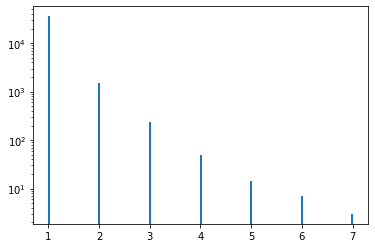

In [55]:
# Repeated questions histogram

plt.hist(qid.value_counts().values,bins=160)
plt.yscale('log')
plt.show()

In [56]:
# Feature Engineering

new_df['q1_len'] = new_df['question1'].str.len() 
new_df['q2_len'] = new_df['question2'].str.len()

In [57]:
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len
331535,331535,169053,295926,How can I learn Norwegian?,What is the quickest way to learn Norwegian?,1,26,44
45407,45407,81383,81384,How are currency rates determined?,Where and how are exchange rates determined?,1,34,44
286200,286200,285024,406729,What is substitution?,What is a substitute for caciocavallo?,0,21,38
157195,157195,245856,245857,How can I make iPhone 4s faster with IOS 9.2?,I have an iPhone 4S. How do I make it faster a...,1,45,73
154346,154346,242075,242076,How can I help my girlfriend cope with her par...,What can I do to help my girlfriend through he...,1,59,64


In [58]:
new_df['q1_num_words'] = new_df['question1'].apply(lambda row: len(row.split(" ")))
new_df['q2_num_words'] = new_df['question2'].apply(lambda row: len(row.split(" ")))
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words
331535,331535,169053,295926,How can I learn Norwegian?,What is the quickest way to learn Norwegian?,1,26,44,5,8
45407,45407,81383,81384,How are currency rates determined?,Where and how are exchange rates determined?,1,34,44,5,7
286200,286200,285024,406729,What is substitution?,What is a substitute for caciocavallo?,0,21,38,3,6
157195,157195,245856,245857,How can I make iPhone 4s faster with IOS 9.2?,I have an iPhone 4S. How do I make it faster a...,1,45,73,10,16
154346,154346,242075,242076,How can I help my girlfriend cope with her par...,What can I do to help my girlfriend through he...,1,59,64,11,12


In [59]:
def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return len(w1 & w2)

In [60]:
new_df['word_common'] = new_df.apply(common_words, axis=1)
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common
331535,331535,169053,295926,How can I learn Norwegian?,What is the quickest way to learn Norwegian?,1,26,44,5,8,2
45407,45407,81383,81384,How are currency rates determined?,Where and how are exchange rates determined?,1,34,44,5,7,4
286200,286200,285024,406729,What is substitution?,What is a substitute for caciocavallo?,0,21,38,3,6,2
157195,157195,245856,245857,How can I make iPhone 4s faster with IOS 9.2?,I have an iPhone 4S. How do I make it faster a...,1,45,73,10,16,5
154346,154346,242075,242076,How can I help my girlfriend cope with her par...,What can I do to help my girlfriend through he...,1,59,64,11,12,8


In [61]:
def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return (len(w1) + len(w2))


In [62]:
new_df['word_total'] = new_df.apply(total_words, axis=1)
new_df.head()


,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total
331535,331535,169053,295926,How can I learn Norwegian?,What is the quickest way to learn Norwegian?,1,26,44,5,8,2,13
45407,45407,81383,81384,How are currency rates determined?,Where and how are exchange rates determined?,1,34,44,5,7,4,12
286200,286200,285024,406729,What is substitution?,What is a substitute for caciocavallo?,0,21,38,3,6,2,9
157195,157195,245856,245857,How can I make iPhone 4s faster with IOS 9.2?,I have an iPhone 4S. How do I make it faster a...,1,45,73,10,16,5,25
154346,154346,242075,242076,How can I help my girlfriend cope with her par...,What can I do to help my girlfriend through he...,1,59,64,11,12,8,23


In [63]:
new_df['word_share'] = round(new_df['word_common']/new_df['word_total'],2)
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share
331535,331535,169053,295926,How can I learn Norwegian?,What is the quickest way to learn Norwegian?,1,26,44,5,8,2,13,0.15
45407,45407,81383,81384,How are currency rates determined?,Where and how are exchange rates determined?,1,34,44,5,7,4,12,0.33
286200,286200,285024,406729,What is substitution?,What is a substitute for caciocavallo?,0,21,38,3,6,2,9,0.22
157195,157195,245856,245857,How can I make iPhone 4s faster with IOS 9.2?,I have an iPhone 4S. How do I make it faster a...,1,45,73,10,16,5,25,0.20
154346,154346,242075,242076,How can I help my girlfriend cope with her par...,What can I do to help my girlfriend through he...,1,59,64,11,12,8,23,0.35


minimum characters 2
maximum characters 315
average num of characters 59


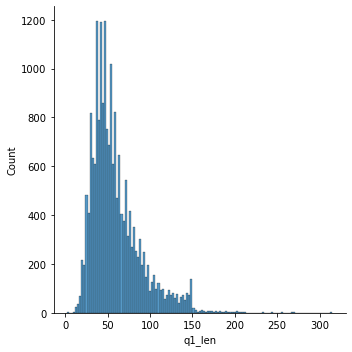

In [64]:
# Analysis of features
sns.displot(new_df['q1_len'])
print('minimum characters',new_df['q1_len'].min())
print('maximum characters',new_df['q1_len'].max())
print('average num of characters',int(new_df['q1_len'].mean()))

minimum characters 11
maximum characters 1169
average num of characters 60


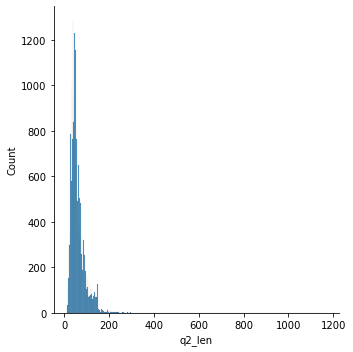

In [65]:
sns.displot(new_df['q2_len'])
print('minimum characters',new_df['q2_len'].min())
print('maximum characters',new_df['q2_len'].max())
print('average num of characters',int(new_df['q2_len'].mean()))

minimum words 1
maximum words 64
average num of words 10


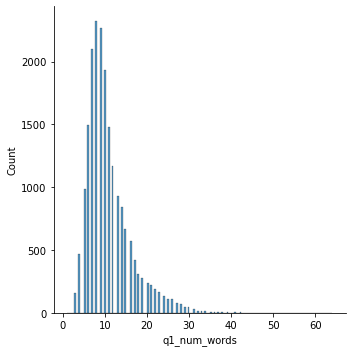

In [66]:
sns.displot(new_df['q1_num_words'])
print('minimum words',new_df['q1_num_words'].min())
print('maximum words',new_df['q1_num_words'].max())
print('average num of words',int(new_df['q1_num_words'].mean()))

minimum words 2
maximum words 237
average num of words 11


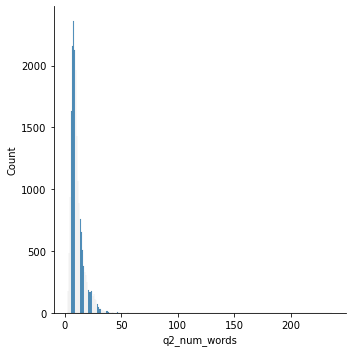

In [67]:
sns.displot(new_df['q2_num_words'])
print('minimum words',new_df['q2_num_words'].min())
print('maximum words',new_df['q2_num_words'].max())
print('average num of words',int(new_df['q2_num_words'].mean()))

C:\Users\ROG ZEPHYRUS\anaconda3\Data science\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ROG ZEPHYRUS\anaconda3\Data science\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


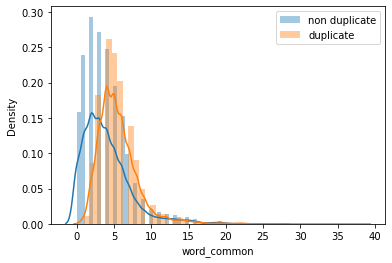

In [68]:
# common words
sns.distplot(new_df[new_df['is_duplicate'] == 0]['word_common'],label='non duplicate')
sns.distplot(new_df[new_df['is_duplicate'] == 1]['word_common'],label='duplicate')
plt.legend()
plt.show()

#From the graph it is shown that

Blue line represents non duplicate

Orange line represents duplicate

We can see that word common :

if in q1 and q2 have 4 or less common words then there are high chances that it is non duplicate 

if in q1 & q2 have greater than 4 then there are high chances that it is duplicate

C:\Users\ROG ZEPHYRUS\anaconda3\Data science\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ROG ZEPHYRUS\anaconda3\Data science\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


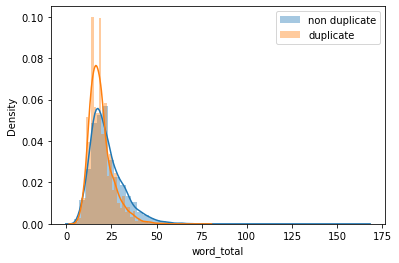

In [69]:
# total words
sns.distplot(new_df[new_df['is_duplicate'] == 0]['word_total'],label='non duplicate')
sns.distplot(new_df[new_df['is_duplicate'] == 1]['word_total'],label='duplicate')
plt.legend()
plt.show()

from the graph it is shown that

total no of words is in between 0 to 20 then there is a high chances it is a duplicate

total no of words is greater than 40 then there is a high chances it is a non duplicate

C:\Users\ROG ZEPHYRUS\anaconda3\Data science\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ROG ZEPHYRUS\anaconda3\Data science\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


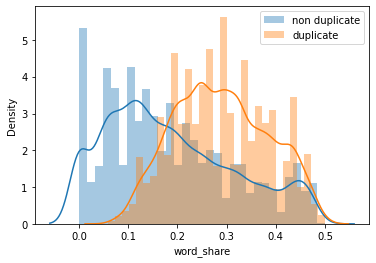

In [70]:
# word share
sns.distplot(new_df[new_df['is_duplicate'] == 0]['word_share'],label='non duplicate')
sns.distplot(new_df[new_df['is_duplicate'] == 1]['word_share'],label='duplicate')
plt.legend()
plt.show()

from graph the graph it is shown that :

if word share is less than 0.2 then there is a high chances it is non duplicate

if word share is greater than 0.2 then there is a high chances it is duplicate

In [71]:
ques_df = new_df[['question1','question2']]
ques_df.head()

,question1,question2
331535,How can I learn Norwegian?,What is the quickest way to learn Norwegian?
45407,How are currency rates determined?,Where and how are exchange rates determined?
286200,What is substitution?,What is a substitute for caciocavallo?
157195,How can I make iPhone 4s faster with IOS 9.2?,I have an iPhone 4S. How do I make it faster a...
154346,How can I help my girlfriend cope with her par...,What can I do to help my girlfriend through he...


In [72]:
final_df = new_df.drop(columns=['id','qid1','qid2','question1','question2'])
print(final_df.shape)
final_df.head()

(20000, 8)


,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share
331535,1,26,44,5,8,2,13,0.15
45407,1,34,44,5,7,4,12,0.33
286200,0,21,38,3,6,2,9,0.22
157195,1,45,73,10,16,5,25,0.20
154346,1,59,64,11,12,8,23,0.35


# TFIDF(Term Frequency and Inverse Document Frequency)

In [85]:
from sklearn.feature_extraction.text import TfidfVectorizer
# merge texts
questions = list(ques_df['question1']) + list(ques_df['question2'])

vectorizer = TfidfVectorizer(max_features=1000)
q1_arr, q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)


In [86]:
temp_df1 = pd.DataFrame(q1_arr, index= ques_df.index)
temp_df2 = pd.DataFrame(q2_arr, index= ques_df.index)
temp_df = pd.concat([temp_df1, temp_df2], axis=1)
temp_df.shape

(20000, 2000)

In [87]:
final_df = pd.concat([final_df, temp_df], axis=1)
print(final_df.shape)
final_df.head()

(20000, 4008)


,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share,0,1,...,990,991,992,993,994,995,996,997,998,999
331535,1,26,44,5,8,2,13,0.15,0,0,...,0,0,0,0,0,0,0,0,0,0
45407,1,34,44,5,7,4,12,0.33,0,0,...,0,0,0,0,0,0,0,0,0,0
286200,0,21,38,3,6,2,9,0.22,0,0,...,0,0,0,0,0,0,0,0,0,0
157195,1,45,73,10,16,5,25,0.20,0,0,...,0,0,0,0,0,0,0,0,0,0
154346,1,59,64,11,12,8,23,0.35,0,0,...,0,0,0,0,0,0,0,0,0,0


# **Model Creation**

In [88]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(final_df.iloc[:,1:].values,final_df.iloc[:,0].values,test_size=0.2,random_state=1)

# **Using Random Forest Classifier**

In [91]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

0.754

# **Using XGBoost Classifier**

In [92]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
accuracy_score(y_test,y_pred)

0.7555

# **CONCLUSION**

In the first part only simple bag of words is applied no other preprocessing is used
after applying the model Random Forest classifer gives 71% accuracy and XGBoost classifier gives 72% accuracy

Dataset was little unbalanced

Size of Dataset is around 4 lakh out of which a sample of 30000 were taken for the preprocessing

In the second part new Feature Engineering is applied in acccordance with instead of Bag of words Tfidf is used
after applying the model Random Forest classifer score of 75.4% and XGBoost Classiifer score of 76%
so XGBoost classifier is taken as the final model